# Cohere Health Machine Learning Assignment 
### By Jennifer Russell

## Step 1: Data Cleaning 

In [1]:
#first we need to import the text files and add the necessary information to a dataframe
import os             
all_files = os.listdir("training_20180910/") 
txt_files = [f for f in all_files if "txt" in f]

In [2]:
#here we will extraxt the necessary information from each patient 
#currently for topic modeling I'm just going to look into extracting the chief complaints and the history of present
#illnesses, however, we may want to come back to add more information

import pandas as pd

def read_txt_files(txt_files):
    medical_history = pd.DataFrame(columns=["chief_complaints", "history"])
    for file in txt_files:  
        with open("training_20180910/" + file, 'rt') as fd:
            first_line = fd.read()
            see_if_chief_complaint = first_line.split('Chief Complaint:')
            if len(see_if_chief_complaint) > 1:
                chief_complaints = first_line.split('Chief Complaint:')[1].split('\n')[1].split(", ")
                see_if_history_of_illness = first_line.split('History of Present Illness:')
                med_history = see_if_history_of_illness[1].split('Past Medical History:')[0].strip()
                
                medical_history = medical_history.append({'chief_complaints':chief_complaints, 'history':med_history}, ignore_index=True)
    return medical_history

med_hist = read_txt_files(txt_files)

In [3]:
#we also want to create functionality to be able to see the lda model based on a given condition
#we must first give every complaint its own relation to the medical history
condition_to_history = pd.DataFrame(columns=["chief_complaints", "history"])

for i, row in med_hist.iterrows():
    complaints = med_hist["chief_complaints"]
    for c in complaints:
        if " and " in c[0]:
            c = c[0].split("and")
        condition_to_history = condition_to_history.append({'complaint':c, 'history':row['history']}, ignore_index=True)

## Step 2: Data Analysis 

In order to start to visualize what the frequent words in the the medical history may be, we make a word cloud

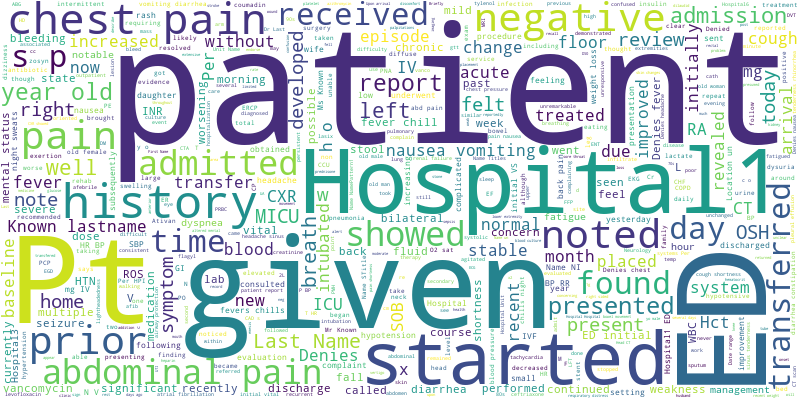

In [4]:
from wordcloud import WordCloud
all_histories = ','.join(list(med_hist['history'].values))
wordcloud = WordCloud(background_color="white", max_words=500, contour_width=3, width=800, height = 400)
wordcloud.generate(all_histories)
wordcloud.to_image()

Here we're noticing that a lot of the words are ones that would come up frequently but wouldn't be very useful in assigning any sort of topic to the group. For example, patient is one of the most frequent words but it probably won't be very useful in terms of making up topics. This indicates to me that we'll want to adjust for frequently appearing words using TF-IDF. 

## Step 3: Data Preprocessing 

In [5]:
#make the text data easier to work with by getting rid of punctuation, uppercase letters, stop words, and more
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords

med_hist['history'] = med_hist['history'].map(lambda x: re.sub('[,\.!?]', '', x))
med_hist['history'] = med_hist['history'].map(lambda x: x.lower())


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jenniferrussell/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jenniferrussell/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Why add so many extra stopwords? 

Usually we wouldn't take out so many extra stopwords. However, in this case we know that we are looking for underlying conditions, so words describing not relevant to actual conditions can be filtered out. There are frequent nouns as patient or hospital, and many verbs that don't make sense to be conditions like find or developed.

In [6]:
stop_words = set(stopwords.words('english'))
stop_words.update(['patient', 'hospital', 'history', 'started', 'showed', 'developed', 'presented', 'day', 'noted', 'admitted', 'given', 
                  'Last Name', 'revealed', 'yesterday', 'mg', 'pt', 'name', 'also', 'last', 'find', 'receive', 'vp', 'per', 'deny', 'report', 'reported', 'recieved', 'iv'])

In [7]:
import gensim
from gensim.utils import simple_preprocess
import gensim.models
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
nltk.download('averaged_perceptron_tagger')

lmr = WordNetLemmatizer()

def stopwords_and_lem(doc):
    return [lmr.lemmatize(word, pos='v') for word in simple_preprocess(str(doc)) 
             if word not in stop_words]

bigram_model = gensim.models.Phrases(med_hist['history'])
bigrams = gensim.models.phrases.Phraser(bigram_model)

for i, row in med_hist.iterrows():
    mid= stopwords_and_lem(row['history'])
#     tokens = text = word_tokenize(row['history'])
    #print(nltk.pos_tag(mid)[0][1])
    mid = [token for token in mid if nltk.pos_tag([token])[0][1] in ['NN', 'VBN', 'VB']]
    row['history'] = bigrams[mid]

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/jenniferrussell/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [8]:
#here we're going to get a dictionary of all the words in our corpus and a corpus which converts the tokens to a BOW
#representation
from gensim.corpora.dictionary import Dictionary
doc_dict = Dictionary(med_hist['history'])
doc_dict.filter_extremes(no_above=0.50)
corpus = [doc_dict.doc2bow(text) for text in med_hist['history']]

In [9]:
from gensim import corpora, models
tfidf = models.TfidfModel(corpus)
tfidf_corpus = tfidf[corpus]

## Step 4: Running the LDA Model

In [10]:
lda_model =  gensim.models.LdaMulticore(corpus, 
                                   num_topics = 10, 
                                   id2word = doc_dict,                                    
                                   passes = 11,
                                   workers = 2)

In [11]:
lda_model_tfidf =  gensim.models.LdaMulticore(tfidf_corpus, 
                                   num_topics = 10, 
                                   id2word = doc_dict,                                    
                                   passes = 11,
                                   workers = 2)

In [12]:
lda_model_tfidf.show_topics(10, formatted = False)

[(0,
  [('leave', 0.005717895),
   ('right', 0.0056397305),
   ('receive', 0.0055243233),
   ('bp', 0.0050227046),
   ('hr', 0.0050171223),
   ('osh', 0.0048906277),
   ('know', 0.0048793806),
   ('discharge', 0.0047938735),
   ('find', 0.004533773),
   ('lastname', 0.004287719)]),
 (1,
  [('pacu', 0.0055110008),
   ('epi', 0.0045777033),
   ('uop', 0.004306395),
   ('syndrome', 0.0041470416),
   ('abd', 0.0031821374),
   ('bmt', 0.0028509113),
   ('epinephrine', 0.0027498135),
   ('kidney', 0.0026781424),
   ('discuss', 0.0026736918),
   ('pm', 0.002547399)]),
 (2,
  [('sedate', 0.007305811),
   ('transfusion', 0.0071072453),
   ('angina', 0.006507012),
   ('drainage', 0.006225664),
   ('tube', 0.0060390276),
   ('graft', 0.0059148627),
   ('epigastric', 0.005269525),
   ('verse', 0.005217479),
   ('stridor', 0.0051290365),
   ('repair', 0.0051193554)]),
 (3,
  [('swell', 0.0070556267),
   ('encephalopathy', 0.0057970006),
   ('food', 0.0055633397),
   ('coronary', 0.004936379),
   ('

## Step 5: Topic Ananlysis 

In [13]:
#here we are going to use the extremely helpful pyLDAvis package to take a deeper dive into the topics that we have predicted
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()
p = gensimvis.prepare(lda_model, corpus, doc_dict)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.008844 -0.035730       1        1  23.895004
9      0.073489 -0.065678       2        1  20.427637
4      0.161465  0.019797       3        1   9.910364
0     -0.027378 -0.031400       4        1   8.890387
5     -0.141435  0.014394       5        1   8.053721
6      0.008538  0.033497       6        1   6.609116
3      0.008902 -0.028348       7        1   6.157119
7     -0.040299 -0.089318       8        1   5.901960
1      0.000820  0.170497       9        1   5.628885
8     -0.052948  0.012289      10        1   4.525807, topic_info=          Term        Freq       Total Category  logprob  loglift
204      right  119.000000  119.000000  Default  30.0000  30.0000
41       leave  134.000000  134.000000  Default  29.0000  29.0000
150      chest  200.000000  200.000000  Default  28.0000  28.0000
97          ct  114.000000  114.000000  Default  27.0000  27.0000
16   discharge  100.000000  100.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
38        know    5.926239   94.548757  Topic10  -5.0371   0.3256
245       call    5.369984   59.730952  Topic10  -5.1357   0.6863
226       year    5.704461  122.026897  Topic10  -5.0752   0.0324
170       find    5.614718  136.682207  Topic10  -5.0911  -0.0969
82          vs    5.252005   86.442669  Topic10  -5.1579   0.2945

[653 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
227       1  0.271282      aaa
227       5  0.180854      aaa
227       7  0.361709      aaa
227      10  0.180854      aaa
0         4  0.335776  abscess
...     ...       ...      ...
85        5  0.038306       yo
85        6  0.063844       yo
85        8  0.127688       yo
85        9  0.025538       yo
85       10  0.038306       yo

[2348 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 10, 5, 1, 6, 7, 4, 8, 2, 9])

In [14]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()
p = gensimvis.prepare(lda_model_tfidf, corpus, doc_dict)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.153041 -0.052944       1        1  61.750621
9     -0.139936 -0.060855       2        1  31.345568
6      0.001536  0.043221       3        1   1.453880
2     -0.006253  0.034275       4        1   1.169181
7     -0.005643  0.023760       5        1   1.067956
8     -0.001968  0.018661       6        1   1.014798
5     -0.008729  0.007991       7        1   0.945920
4      0.006315  0.006086       8        1   0.589314
3     -0.001033  0.002477       9        1   0.484397
1      0.002669 -0.022671      10        1   0.178365, topic_info=            Term       Freq      Total Category  logprob  loglift
204        right  76.000000  76.000000  Default  30.0000  30.0000
114          osh  71.000000  71.000000  Default  29.0000  29.0000
14          deny  99.000000  99.000000  Default  28.0000  28.0000
226         year  52.000000  52.000000  Default  27.0000  27.0000
16     discharge  63.000000  63.000000  Default  26.0000  26.0000
..           ...        ...        ...      ...      ...      ...
369        stage   0.066942  13.302589  Topic10  -6.2867   1.0372
390     daughter   0.083865  33.304399  Topic10  -6.0613   0.3449
456      endorse   0.073218  22.371298  Topic10  -6.1971   0.6070
301   hematocrit   0.069365  16.303328  Topic10  -6.2511   0.8694
35   improvement   0.067289  30.756356  Topic10  -6.2815   0.2042

[497 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
227       1  0.855317   aaa
227       2  0.047518   aaa
227       4  0.047518   aaa
382       1  0.039799   abd
382       2  0.875571   abd
...     ...       ...   ...
226       1  0.820368  year
226       2  0.133548  year
85        1  0.832283    yo
85        2  0.118898    yo
85        3  0.019816    yo

[927 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 10, 7, 3, 8, 9, 6, 5, 4, 2])

In [15]:
from gensim.models.coherencemodel import CoherenceModel

coherence_model_lda = CoherenceModel(model=lda_model, texts=med_hist["history"], dictionary=doc_dict, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score for BOW Model: ', coherence_lda)

Coherence Score for BOW Model:  0.383034100625026


In [16]:
from gensim.models.coherencemodel import CoherenceModel

coherence_model_lda = CoherenceModel(model=lda_model_tfidf, texts=med_hist["history"], dictionary=doc_dict, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score for TF_IDF Model ', coherence_lda)

Coherence Score for TF_IDF Model  0.49142483569171047


Here we can see the TF_IDF Model has a much higher coherence score so we know that the topics contrived from that model should be more 'readable' and 'understandable' to humans. We can see out of the 5 topics, there is one main topic and 4 much smaller, much more specific topics. These smaller ones will be very helpful when a disease is thought to be mapped to these smaller topics. 

## Step 6: LDA Model Tuning

After calculating the coherence scores for each number of topics between 1-15, we know the optimal number of topics is around 9, which had the highest coherence score of about 9. Now, we will run initial tuning models on other factors, and then do some final tuning where we put many of the paramaterizations together to find our optized model parameters. To save space, I have not included the code from all of the initial tuning trials but just the last tunings

In [17]:
number_of_topics = [8, 10, 12]
passes = [10,11,12, 14]
#alpha shoud be kept as default (symmetric)
#changing the min prob didnt make a difference

In [18]:
for i in number_of_topics:
    for k in passes:
        lda_tuning_model =  gensim.models.LdaMulticore(tfidf_corpus, 
                                       num_topics = i, 
                                       id2word = doc_dict,                                    
                                       passes = k,
                                       workers = 2,
                                        random_state = 42,
                                        )

        coherence_model_lda = CoherenceModel(model=lda_tuning_model, texts=med_hist["history"], dictionary=doc_dict, coherence='c_v')
        coherence_lda = coherence_model_lda.get_coherence()
        print('Number of topics: ', i)
        print('Number of passes: ', k)
        print('Coherence Score for Tuning Model ', coherence_lda)
        print('\n')

Number of topics:  8
Number of passes:  10
Coherence Score for Tuning Model  0.4394476955125728


Number of topics:  8
Number of passes:  11
Coherence Score for Tuning Model  0.4524377785254182


Number of topics:  8
Number of passes:  12
Coherence Score for Tuning Model  0.4573057723522923


Number of topics:  8
Number of passes:  14
Coherence Score for Tuning Model  0.45079242052434876


Number of topics:  10
Number of passes:  10
Coherence Score for Tuning Model  0.4964819382598417


Number of topics:  10
Number of passes:  11
Coherence Score for Tuning Model  0.5075015187675777


Number of topics:  10
Number of passes:  12
Coherence Score for Tuning Model  0.5099433939546999


Number of topics:  10
Number of passes:  14
Coherence Score for Tuning Model  0.4960501730327221


Number of topics:  12
Number of passes:  10
Coherence Score for Tuning Model  0.4904015125028889


Number of topics:  12
Number of passes:  11
Coherence Score for Tuning Model  0.4811719657929834


Number of top

In [19]:
med_hist['history']

0      [mr, know, lastname, yo, male, arthritis, ther...
1      [ms, know, lastname, schizoaffective, disorder...
2      [year, dr, heart, disease, moderate, mr, title...
3      [rupture, aaa, repair, dacron, tube, graft, in...
4      [year, male, multiple, sclerosis, baseline, co...
                             ...                        
265    [present, ed, nausea, vomit, diaphoresis, dist...
266                                                   []
267    [year, gentleman, chest, pain, exertion, stres...
268    [rny, gastric, bypass, cholecystectomy, pound,...
269    [chf, ef, echo, fibrillation, coumadin, transf...
Name: history, Length: 270, dtype: object

Our best coherence score came from when the model had 10 topics and 11 passes, so these are the parameters we will use throughout the rest of the analysis

## Step 7: Putting It All Together for Conditional Topics

In [20]:
#we also want to create functionality to be able to see the lda model based on a given condition
#we must first give every complaint its own relation to the medical history
from collections import defaultdict

condition_to_history = pd.DataFrame(columns=["complaint", "history"])
condition_dict = defaultdict(list)

for i, row in med_hist.iterrows():
    complaints = row["chief_complaints"]
    for c in complaints:
        if " and " in c:
            c = c.split("and")
        else:
            c = [c]
        for com in c:
            if com != [""]:
                condition_to_history = condition_to_history.append({'complaint':com, 'history':row['history']}, ignore_index=True)
                condition_dict[com].append(i)
            

In [21]:
condition_dict

defaultdict(list,
            {'L leg pain ': [0],
             ' erythema': [0],
             'Stridor': [1, 6],
             'chest pain': [2, 107, 137, 179],
             'hypotension': [2, 113, 130, 187, 220],
             'aortoenteric fistula': [3],
             'hypoxia': [4],
             'GI bleed': [5, 19, 101],
             'headache': [7, 65, 240, 266],
             'nauesa/vomiting': [7],
             'vertigo': [7],
             'Decreasing hematocrit': [8],
             'right thigh hematoma ': [8],
             ' decreased urine': [8],
             'post-op bleeding after tooth extraction': [9],
             'fatigue': [10, 175],
             'elevated WBC': [10],
             'Hypotension': [11, 38, 63, 156, 172, 192, 236],
             'fever': [11, 21, 24, 96, 104, 211, 255],
             'R-sided weakness ': [12],
             ' R facial droop': [12],
             's/p recent fall with "inability to walk."': [13],
             'Headache': [14, 159],
             'Lo

In [22]:
med_hist['history']

0      [mr, know, lastname, yo, male, arthritis, ther...
1      [ms, know, lastname, schizoaffective, disorder...
2      [year, dr, heart, disease, moderate, mr, title...
3      [rupture, aaa, repair, dacron, tube, graft, in...
4      [year, male, multiple, sclerosis, baseline, co...
                             ...                        
265    [present, ed, nausea, vomit, diaphoresis, dist...
266                                                   []
267    [year, gentleman, chest, pain, exertion, stres...
268    [rny, gastric, bypass, cholecystectomy, pound,...
269    [chf, ef, echo, fibrillation, coumadin, transf...
Name: history, Length: 270, dtype: object

In [53]:
#use this to visualize the topics that arise in the documents for any singular chief complaint
def find_topics_for_complaint(complaint):
    
    condition_histories = condition_to_history[condition_to_history["complaint"] == complaint]
    
    bigram_model = gensim.models.Phrases(condition_histories['history'])
    bigrams = gensim.models.phrases.Phraser(bigram_model)
    

    for i, row in condition_histories.iterrows():
        mid= stopwords_and_lem(row['history'])
        mid = [token for token in mid if nltk.pos_tag([token])[0][1] in ['NN', 'VBN', 'VB']]
        row['history'] = bigrams[mid]
        condition_histories.loc[i] = row
    
    
    doc_dict = Dictionary(condition_histories['history'])
    print(doc_dict)
#     doc_dict.filter_extremes(no_above=0.8)
    corpus = [doc_dict.doc2bow(text) for text in condition_histories['history']]
    
    tfidf = models.TfidfModel(corpus)
    tfidf_corpus = tfidf[corpus]
    
    lda_model_tfidf =  gensim.models.LdaModel(tfidf_corpus, 
                                   num_topics = 8, 
                                   id2word = doc_dict,                                    
                                   passes = 11)
    pyLDAvis.enable_notebook()
    p = gensimvis.prepare(lda_model_tfidf, corpus, doc_dict)
    return p

In [54]:
find_topics_for_complaint("hypotension")

/Users/jenniferrussell/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/jenniferrussell/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Dictionary(341 unique tokens: ['activity', 'acute', 'addition', 'afebrile', 'ambulance']...)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.000385  0.005457       1        1  33.567573
0      0.006087  0.006777       2        1  29.931395
7     -0.013688 -0.006296       3        1  17.204961
1      0.009864 -0.011791       4        1  10.842510
4     -0.001517  0.005958       5        1   8.116319
3     -0.000120 -0.000035       6        1   0.112414
5     -0.000120 -0.000035       7        1   0.112414
6     -0.000120 -0.000035       8        1   0.112414, topic_info=           Term      Freq     Total Category  logprob  loglift
213     culture  2.000000  2.000000  Default  30.0000  30.0000
249    multiple  2.000000  2.000000  Default  29.0000  29.0000
241        lobe  2.000000  2.000000  Default  28.0000  28.0000
289      weight  2.000000  2.000000  Default  27.0000  27.0000
230       haart  2.000000  2.000000  Default  26.0000  26.0000
..          ...       ...       ...      ...      ...      ...
150          rr  0.001813  1.572873   Topic8  -5.8319   0.0251
168        call  0.001813  1.562360   Topic8  -5.8319   0.0318
236         leg  0.001813  1.594587   Topic8  -5.8319   0.0114
285  vancomycin  0.001813  1.594587   Topic8  -5.8319   0.0114
290      worsen  0.001813  1.594587   Topic8  -5.8319   0.0114

[389 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
0         2  0.548559  activity
3         2  0.633871  afebrile
191       1  0.635449        ag
193       1  0.635449       aid
5         1  0.621633  anterior
...     ...       ...       ...
116       2  0.626225  weakness
117       2  0.549922      week
289       1  0.486226    weight
290       1  0.627122    worsen
119       2  0.639122      year

[129 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 8, 2, 5, 4, 6, 7])

## Step 8: Getting a model to represent underlying conditions for every chief complaint

We can use the Author Topic Model, which uses LDA models, like the ones we explored earlier in the Jupyter notebook, to get the underlying conditions for every complaint. This will have a faster run time than calling the individual LDA function like the one created above. We have already created the complaint dictonary mapping complaints to the patient files associated with that complaint.

In [55]:
print('Number of authors: %d' % len(condition_dict))
print('Number of unique tokens: %d' % len(doc_dict))
print('Number of documents: %d' % len(corpus))

Number of authors: 284
Number of unique tokens: 956
Number of documents: 270


In [56]:
from gensim.models import AuthorTopicModel

num_topics = [5,6,7, 8]
passes = [22, 24, 26, 28]

for n in num_topics:
    for p in passes:
        print("Topics: " + str(n))
        print("Passes: " + str(p))
        model = AuthorTopicModel(
            corpus=corpus, 
            num_topics=n, 
            id2word=doc_dict, 
            author2doc=condition_dict, 
            passes=p)

        coherence_model_authtop = CoherenceModel(model=model, texts=med_hist["history"], dictionary=doc_dict, coherence='c_v')
        coherence_authTop = coherence_model_authtop.get_coherence()
        print('Coherence Score for Author Topic ', coherence_authTop)
        print("\n")

Topics: 5
Passes: 22
Coherence Score for Author Topic  0.42701795683456406


Topics: 5
Passes: 24
Coherence Score for Author Topic  0.40953567639648175


Topics: 5
Passes: 26
Coherence Score for Author Topic  0.3950147445077451


Topics: 5
Passes: 28
Coherence Score for Author Topic  0.3900421419451506


Topics: 6
Passes: 22
Coherence Score for Author Topic  0.4126711756800478


Topics: 6
Passes: 24
Coherence Score for Author Topic  0.3856402054291368


Topics: 6
Passes: 26
Coherence Score for Author Topic  0.41356927006397565


Topics: 6
Passes: 28
Coherence Score for Author Topic  0.406794259100897


Topics: 7
Passes: 22
Coherence Score for Author Topic  0.39859768975620474


Topics: 7
Passes: 24
Coherence Score for Author Topic  0.38505273681449


Topics: 7
Passes: 26
Coherence Score for Author Topic  0.3800041484505144


Topics: 7
Passes: 28
Coherence Score for Author Topic  0.3757877859462076


Topics: 8
Passes: 22
Coherence Score for Author Topic  0.336395370269413


Topics: 8
Pa

In [60]:
#Final model will have 6 topics, 26 passes
model = AuthorTopicModel(
            corpus=corpus, 
            num_topics=6, 
            id2word=doc_dict, 
            author2doc=condition_dict, 
            passes=26)

coherence_model_authtop = CoherenceModel(model=model, texts=med_hist["history"], dictionary=doc_dict, coherence='c_v')
coherence_authTop = coherence_model_authtop.get_coherence()
print('Coherence Score for Author Topic ', coherence_authTop)

Coherence Score for Author Topic  0.37695593892247087


In [65]:
#we know we should use the tfidf topics since that model has the better coherence score, meaning the topics will be more 'human friendly'
topics = {}
auth_topics = {}
author_list = model.id2author.values()

model_topics = model.show_topics(7, formatted=False)
   
for i, row in model_topics:
    word_list = [r[0] for r in row]
    topics[i] = word_list

k = 0
for a in author_list:
    if a != '':
        author_topic_dist = model.get_author_topics(a)
        top = max(author_topic_dist)[0]
        auth_topics[a] = topics.get(top)
        k+=1

In [72]:
def show_author(name):
    print('\n%s' % name)
    print('Docs:', model.author2doc[name])
    print('Topics:')
    print([(topic[0], topic[1]) for topic in model[name]])

In [73]:
for a in author_list:
    if a != "":
        show_author(a)


 Chest pain
Docs: [224]
Topics:
[(2, 0.030138569966314626), (3, 0.9421496450925282)]

 Hypotension
Docs: [263]
Topics:
[(1, 0.05948806062217419), (4, 0.9244787248724772)]

 LE edema
Docs: [134]
Topics:
[(1, 0.8072391521165027), (2, 0.09193258107495182), (3, 0.03363434167285468), (5, 0.06107476089612297)]

 R facial droop
Docs: [12]
Topics:
[(0, 0.14565765593123595), (1, 0.15929787101765103), (4, 0.6217534230859287), (5, 0.06551675109582052)]

 abdominal pain
Docs: [22]
Topics:
[(0, 0.015261733773207718), (1, 0.07455992953567236), (2, 0.47990502715981304), (5, 0.4254621468033142)]

 bowel leakage
Docs: [91]
Topics:
[(0, 0.97307953046148)]

 confusion
Docs: [269]
Topics:
[(0, 0.024044879539765526), (1, 0.9637519247536481)]

 decreased movement of the
Docs: [18]
Topics:
[(2, 0.04077933838540679), (5, 0.9424885591302163)]

 decreased urine
Docs: [8]
Topics:
[(1, 0.9649755663100572)]

 erythema
Docs: [0]
Topics:
[(0, 0.03530822041813764), (1, 0.40519289094844324), (5, 0.5507163953131539)]


In [74]:
auth_topics

{' Chest pain': ['deny',
  'brain',
  'treat',
  'require',
  'vs',
  'icu',
  'cxr',
  'course',
  'ruq',
  'infection'],
 ' Hypotension': ['deny',
  'chest',
  'change',
  'nausea',
  'vomit',
  'chill',
  'report',
  'cough',
  'headache',
  'diarrhea'],
 ' LE edema': ['know',
  'blood',
  'bleed',
  'chest',
  'stool',
  'year',
  'discharge',
  'po',
  'lastname',
  'home'],
 ' R facial droop': ['know',
  'blood',
  'bleed',
  'chest',
  'stool',
  'year',
  'discharge',
  'po',
  'lastname',
  'home'],
 ' abdominal pain': ['know',
  'blood',
  'bleed',
  'chest',
  'stool',
  'year',
  'discharge',
  'po',
  'lastname',
  'home'],
 ' bowel leakage': ['find',
  'head',
  'intubate',
  'seizure',
  'wife',
  'felt',
  'time',
  'ct',
  'ativan',
  'speech'],
 ' confusion': ['deny',
  'right',
  'chest',
  'leave',
  'bp',
  'receive',
  'hr',
  'find',
  'cough',
  'review'],
 ' decreased movement of the': ['know',
  'blood',
  'bleed',
  'chest',
  'stool',
  'year',
  'discharge'

In [75]:
df = pd.DataFrame(columns=['Complaint', 'Topic'])
for i in auth_topics:
    df = df.append({'Complaint':i, 'Topic':auth_topics[i]}, ignore_index=True)

df.to_csv("results.csv")

/Users/jenniferrussell/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/jenniferrussell/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/jenniferrussell/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/jenniferrussell/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/jenniferrussell/opt/anaconda3

## Step 9: Final Conclusions

Finding an accurate way to model the topic data was challenging due to the the amount of information unrelated to the underlying conditions of the patient. Each 'History of Medical Illness' section was quite lengthy and included a lot of information that wasn't actually helpful to discovering underlying conditions. In a NLP engineers dream world, prior conditions would be listed seperately.

LDA is a commonly taken approach for both topic modeling and dimensionality reduction. We used this approach since we needed to find the topics surrounding unsupervised patient data. However, the LDA model makes many assumptions that we cannot gauruntee, like the fact that a LDA model relies on a Gaussian distribution. This means that the LDA model assumes the topics are normally distributed, whereas we have no idea what the actual distribution of the data looks like. To try to combat the gaussian assumption, we moved on to using the author topic model, which is an extension of LDA, but each chief illness (the 'author') will have a multinomial distribution over the topics. This helps find the similarities/main topics between all patient histories associated with an illness.

The results of my LDA analysis were okay. We were able to get the Coherence scores up from about 30% to 35% with some fine-tuning some of the model parameters. We wanted to use the tf-idf representation instead of BOW, however, the Author Topic model was not compatible with the transformation. In work earlier on in the analysis, we can see that the Coherence score for the LDA with tf-idf transformations was much higher, around 50%. If there was a fast way to get topics per author using the LDA model instead of the Author Topic Model, the topics might be more accurate. Once we utilized the Author Topic Model, there was a sharp decrease in difference between the tfidf and the bow representations, since the Author Topic Model accounts for a lot of the similarities in words common accross many topics. However, the presence of so much unnecessary text made using the History of Present Illness section as our main text unreliable. Even with the removal of several specific stopwords, most of the predictions our model came up with were general in nature. 

If I were to further my analysis, I would want to see if there was any other patient records we could access that might have more information about underlying conditions. I would also spend more time adding the named entity annotations as a feature for the documents to have entity linking improve the performance of the topic modeling. I would also suggest consulting experts in the field to consult on what medical related stop words could be added to the stopword list. I made a list of words that seemed unrelated to the specific underlying conditions but came up frequently, but the expertise of a medical professional would help ensure that the list is as accurate as possible. 

As seen in the LDA analysis visualizations, there are many different topics related to the underlying conditions. However, there are a few more general topics that the model seems to predict quite frequently. I would suggest 